# Issue Passport Details Credential

## This notebook walks through how to issue a credential across a newly established connection with a mobile SSI agent. 

## Before running through this notebook you should run through the following notebook - [Part 2](http://localhost:8889/notebooks/Part%202%20-%20Initialising%20the%20ID%20Verification%20Agent.ipynb).

If unfamiliar with the protocol it is worth reading through the [aries-rfs](https://github.com/hyperledger/aries-rfcs/tree/master/features/0036-issue-credential)


## 1. Initialise a controller for Issuer

In [14]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8052
WEBHOOK_BASE = ""
ADMIN_URL = "http://id-verifier-agent:8051"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [15]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3. Copy across the cred_def_id you created in Part 2

In [18]:
## YOU SHOULD BE COPYING YOUR OWN DEFINITION HERE

cred_def_id = 'DoCBTjSZg13RUULoiBwRsH:3:CL:141253:default'

## 4. Populate the Passport Details to Issue to Doctor

This would typically be done through a face to face identity check.

The notebook will ask you to input all the relevant fields.

In [2]:
passport_num = input("Please enter the doctors pasport number: ")
surname=input("Please enter the doctors surname: ")
given_names=input("Please enter the doctors given names: ")
nationality = input("Please enter the doctors nationality: ")
dob=input("Please enter the doctors date of birth: ")
sex=input("Please enter the doctors gender: ")
place_of_birth = input("Please enter the doctors place of birth: ")
date_of_issue=input("Please enter the date: ")
issuing_auth=input("Please enter the issuing authority: ")
expiry_date = input("Please enter the expiry date: ")
photograph=input("Please enter a photograph of the doctor: ")
signature=input("Please enter your signature: ")
credential_attributes = [
    {"name": "PSS Passport No", "value": passport_num},
    {"name": "PSS Surname", "value": surname},
    {"name": "PSS Given Names", "value": given_names},
    {"name": "PSS Nationality", "value": nationality},
    {"name": "PSS Date of Birth", "value": dob},
    {"name": "PSS Sex", "value": sex},
    {"name": "PSS Place of Birth", "value": place_of_birth},
    {"name": "PSS Date of Issue", "value": date_of_issue},
    {"name": "PSS IssuingAuthority", "value": issuing_auth},
    {"name": "PSS Date of Expiry", "value": expiry_date},
    {"name": "PSS Photograph", "value": photograph},
    {"name": "PSS Signature", "value": signature},

]



print(credential_attributes)

Please enter the doctors pasport number: 123123123
Please enter the doctors surname: Abramson
Please enter the doctors given names: Will
Please enter the doctors nationality: British
Please enter the doctors date of birth: 24/02/10
Please enter the doctors gender: Male
Please enter the doctors place of birth: Bradford
Please enter the date: 21/09/20
Please enter the issuing authority: BTH
Please enter your pasport number: 12/12/22
Please enter a photograph of the doctor: a base 64 photo string
Please enter your signature: oiqweurj
[{'name': 'PSS Passport No', 'value': '123123123'}, {'name': 'PSS Surname', 'value': 'Abramson'}, {'name': 'PSS Given Names', 'value': 'Will'}, {'name': 'PSS Nationality', 'value': 'British'}, {'name': 'PSS Date of Birth', 'value': '24/02/10'}, {'name': 'PSS Sex', 'value': 'Male'}, {'name': 'PSS Place of Birth', 'value': 'Bradford'}, {'name': 'PSS Date of Issue', 'value': '21/09/20'}, {'name': 'PSS IssuingAuthority', 'value': 'BTH'}, {'name': 'PSS Date of Exp

## 7. Make sure you have a Mobile SSI Wallet dowloaded and configured to using the Sovrin StagingNet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 8. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scan this QR code and then communicate back to the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

## 8a. Create an Invitation

In [16]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection ID db94b882-951c-43e6-8be1-8c47cb101e9c
Invitation
https://599d28fc1a17.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiNTQxYjViNDctYWE3Zi00MWExLTk1MzctYzEzN2IzYjI5ODg2IiwgImxhYmVsIjogIklkZW50aXR5IFZlcmlmaWNhdGlvbiBTZXZpY2UiLCAicmVjaXBpZW50S2V5cyI6IFsiQmJNM3Q3ODlFQXFhVHBRZTcxNG5IZk5UWEJZWFhmU1VLaGk1R3pFMnVjTjUiXSwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwczovLzU5OWQyOGZjMWExNy5uZ3Jvay5pbyJ9


## 8b. Generate QR Code to be scanned with Mobile SSI Wallet

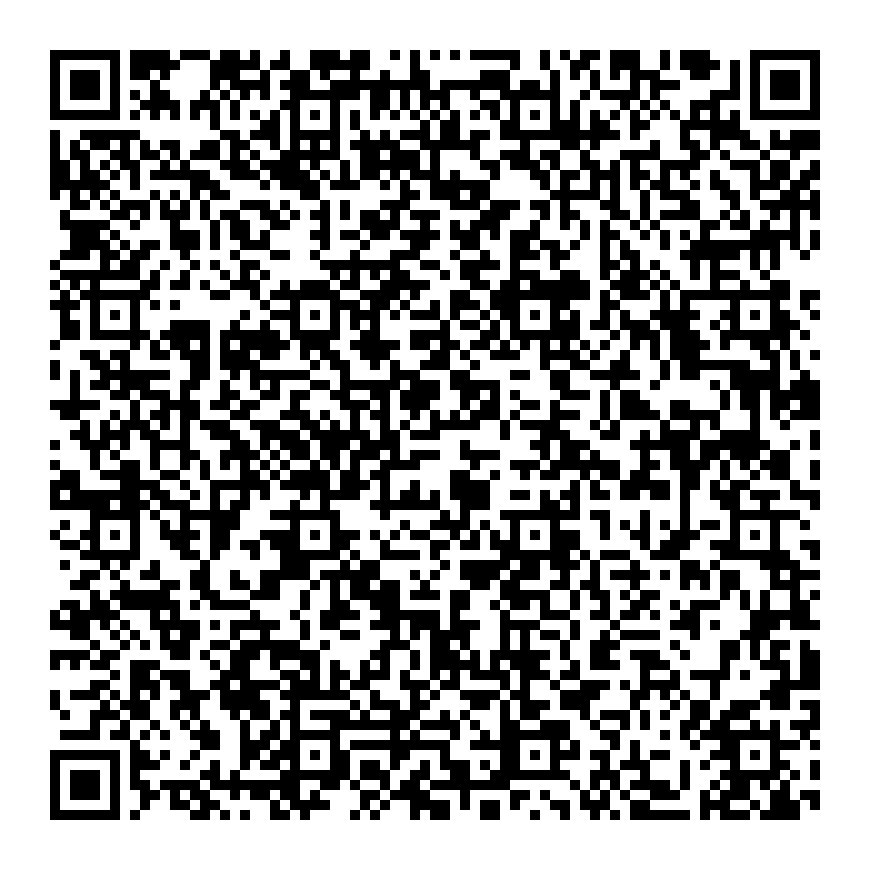

In [17]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)

qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

## 8c. Check if established connection is in active state

In [9]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


NameError: name 'STATE' is not defined

## 9. Send Credential

This sends a credential to the doctor's mobile wallet you just connected with.

In [17]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


{'issuer_did': 'XWp3vCdafbfAEthny5mERo', 'auto_remove': True, 'credential_proposal': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/issue-credential/1.0/credential-preview', 'attributes': [{'name': 'fullname', 'value': 'Ronnie'}, {'name': 'skill', 'value': 'PyDentity SSI Ninja'}, {'name': 'age', 'value': '23'}]}, 'connection_id': 'd36df176-2428-46e4-937d-26eef701d292', 'trace': False, 'comment': '', 'cred_def_id': 'XWp3vCdafbfAEthny5mERo:3:CL:142409:default', 'schema_id': 'EuEtnVakYFyBtGFT1nHYtH:2:SSI PyDentity Tutorial:0.0.1', 'schema_name': 'SSI PyDentity Tutorial', 'schema_version': '0.0.1', 'schema_issuer_did': 'EuEtnVakYFyBtGFT1nHYtH'}
Credential exchange 8f4d27a9-9034-45cc-829d-47514c7c976b, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 8f4d27a9-9034-45cc-829d-47514c7c976b, role: issuer, state: offer_sent
Offering: [{'name': 'fullname', 'value': 'Ronnie'}, {'name': 'skill', 'value': 'PyDentity SSI Ninja'}, {'name': 'age', 'value': '23'}]
Handle Credential

## 10. Accept credential in Mobile SSI Wallet

## 11. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [13]:
response = await agent_controller.terminate()
print(response)

None


# You can now proceed to interact with the Medical School  [Medical School](http://127.0.0.1:8888)

Here you will present the attributes issued to you within this tutorial to a verifying entity.